# Clean Street Quality Data and Merge to Citibike Data

In [1]:
# Import geojson file into geopandas dataframe and remove streets with no rating
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

st_quality = gpd.read_file('../data/external/street-assessment/StreetAssessmentRating/StreetAssessmentRating.shp')
st_quality = st_quality[['Rating_B', 'geometry']]
st_quality = st_quality[st_quality.Rating_B != 0 ]
st_quality = st_quality.to_crs({'init' :'epsg:4326'})
st_quality.head()

,Rating_B,geometry
5,8,LINESTRING (-74.25505718173608 40.505211202903...
6,8,LINESTRING (-74.25422295126869 40.506165510193...
7,8,LINESTRING (-74.25317481600686 40.504767963701...
8,7,LINESTRING (-74.25309430129053 40.506297011897...
9,6,LINESTRING (-74.25493722035239 40.507701030728...


In [2]:
# Check crs
st_quality.crs

{'init': 'epsg:4326'}

In [3]:
# Import citibike station csv into geopandas dataframe
from shapely.geometry import Point

stations = pd.read_csv('../data/processed/stations.csv')

geometry = gpd.GeoSeries([Point(xy) for xy in zip(stations.Longitude, stations.Latitude)])
geometry = geometry.buffer(.0005)
geo_stations = gpd.GeoDataFrame(stations, geometry=geometry)
geo_stations.crs = {'init' :'epsg:4326'}
geo_stations.head()

,Station_id,Station_Name,Location,Latitude,Longitude,geometry
0,72,W 52 St & 11 Ave,W 52 St & 11 Ave,40.767272,-73.993929,"POLYGON ((-73.99342888 40.76727216, -73.993431..."
1,79,Franklin St & W Broadway,Franklin St & W Broadway,40.719116,-74.006667,"POLYGON ((-74.00616660999999 40.71911552, -74...."
2,82,St James Pl & Pearl St,St James Pl & Pearl St,40.711174,-74.000165,"POLYGON ((-73.99966544999999 40.71117416, -73...."
3,83,Atlantic Ave & Fort Greene Pl,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,"POLYGON ((-73.97582328 40.68382604, -73.975825..."
4,116,W 17 St & 8 Ave,W 17 St & 8 Ave,40.741776,-74.001497,"POLYGON ((-74.00099745999999 40.74177603, -74...."


In [4]:
# Check number of stations before merge
len(geo_stations)

664

In [5]:
# Check crs
geo_stations.crs

{'init': 'epsg:4326'}

In [6]:
# Merge street quality data with citibike stations using Geopandas Spatial Merge
stations_st_quality = gpd.sjoin(geo_stations, st_quality, how="inner", op='intersects')
stations_st_quality.drop(['index_right', 'Location'], axis=1, inplace=True)
stations_st_quality.head(10)

,Station_id,Station_Name,Latitude,Longitude,geometry,Rating_B
0,72,W 52 St & 11 Ave,40.767272,-73.993929,"POLYGON ((-73.99342888 40.76727216, -73.993431...",8
0,72,W 52 St & 11 Ave,40.767272,-73.993929,"POLYGON ((-73.99342888 40.76727216, -73.993431...",8
0,72,W 52 St & 11 Ave,40.767272,-73.993929,"POLYGON ((-73.99342888 40.76727216, -73.993431...",8
1,79,Franklin St & W Broadway,40.719116,-74.006667,"POLYGON ((-74.00616660999999 40.71911552, -74....",9
1,79,Franklin St & W Broadway,40.719116,-74.006667,"POLYGON ((-74.00616660999999 40.71911552, -74....",8
1,79,Franklin St & W Broadway,40.719116,-74.006667,"POLYGON ((-74.00616660999999 40.71911552, -74....",9
1,79,Franklin St & W Broadway,40.719116,-74.006667,"POLYGON ((-74.00616660999999 40.71911552, -74....",9
1,79,Franklin St & W Broadway,40.719116,-74.006667,"POLYGON ((-74.00616660999999 40.71911552, -74....",8
1,79,Franklin St & W Broadway,40.719116,-74.006667,"POLYGON ((-74.00616660999999 40.71911552, -74....",8
1,79,Franklin St & W Broadway,40.719116,-74.006667,"POLYGON ((-74.00616660999999 40.71911552, -74....",9


In [7]:
# Find average of street quality ratings for each station
stations_st_quality = stations_st_quality.groupby(['Station_id', 'Station_Name', 'Latitude', 'Longitude']).mean()
stations_st_quality.reset_index(inplace=True)
stations_st_quality.head()

,Station_id,Station_Name,Latitude,Longitude,Rating_B
0,72,W 52 St & 11 Ave,40.767272,-73.993929,8.000000
1,79,Franklin St & W Broadway,40.719116,-74.006667,8.571429
2,82,St James Pl & Pearl St,40.711174,-74.000165,7.333333
3,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,7.500000
4,116,W 17 St & 8 Ave,40.741776,-74.001497,8.500000


In [8]:
# Check number of stations after merge
len(stations_st_quality)

604

In [9]:
# Output merged file to csv
stations_st_quality.drop(['Station_Name', 'Latitude', 'Longitude'], axis=1, inplace=True)
# Save to CSV
stations_st_quality.to_csv("../data/processed/street-assessment.csv")

In [1]:
# Visualize the Data Points

In [10]:
stations_st_quality.head()

,Station_id,Rating_B
0,72,8.000000
1,79,8.571429
2,82,7.333333
3,83,7.500000
4,116,8.500000


In [41]:
Station_counts0 = stations_st_quality['Station_id'].groupby(stations_st_quality['Rating_B']).count()

In [54]:
Station_counts0[:5]

Rating_B
4.0    1
4.8    1
5.0    5
Name: Station_id, dtype: int64

In [65]:
Station_counts = Station_counts0.to_frame()
Station_counts.reset_index(inplace=True)

In [66]:
Station_counts.columns

Index([u'Rating_B', u'Station_id'], dtype='object')

In [67]:
Station_counts.columns = ['Rating_B', 'Station_counts']
Station_counts.sort_values(by='Rating_B', inplace=True)
Station_counts.head()

,Rating_B,Station_counts
0,4.000000,1
1,4.800000,1
2,5.000000,5
3,5.500000,2
4,5.666667,1


In [68]:
len(Station_counts)

59

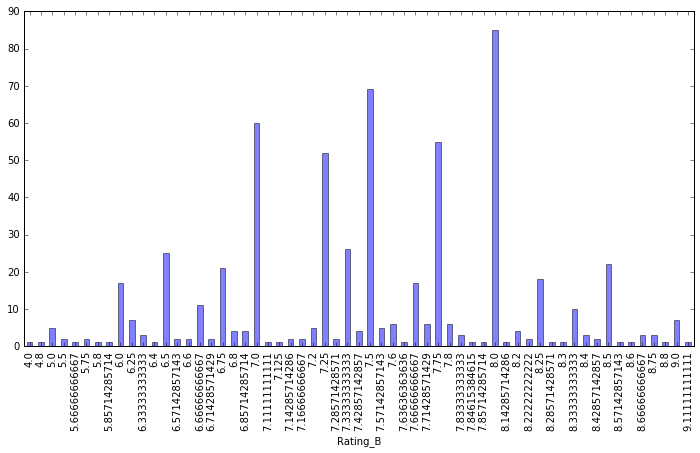

In [64]:
# use pandas series to plot the histogram
fig = plt.figure(figsize=(12,6))

Station_counts0.plot(kind="bar", alpha=0.5)

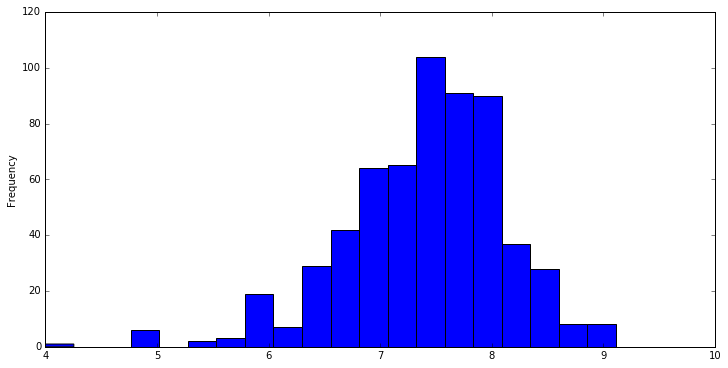

In [62]:
# use the stations_st_quality dataframe to plot the histogram
fig2 = plt.figure(figsize=(12,6))

stations_st_quality['Rating_B'].plot.hist(by='Rating_B', bins=20)